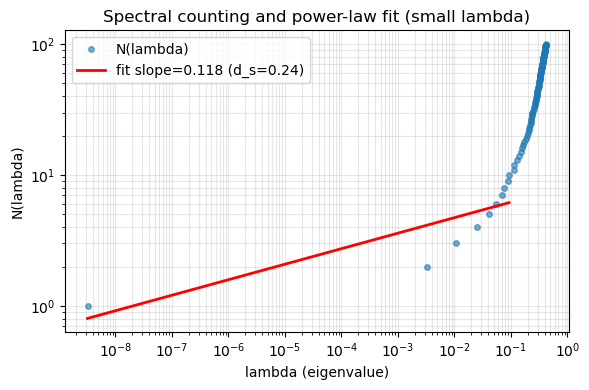

Summary:
 - lambda_max_for_fit: 0.1
 - n_points_fit: 10
 - slope: 0.11841938835448512
 - intercept: 2.0975113473762486
 - r_value: 0.8464325151655236
 - p_value: 0.0020128567771838593
 - stderr_slope: 0.02633915495494502
 - d_s_est: 0.23683877670897024
 - d_s_se: 0.05267830990989004
Saved counting CSV: results/spectral_dimension_counting.csv
Saved summary CSV: results/spectral_dimension_summary.csv
Saved fit plot: results/spectral_dimension_fit.png


In [3]:
# Cell: Estimate spectral dimension ds from Laplacian eigenvalues using spectral counting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os

# Parameters (adjustable)
eig_csv = 'results/laplacian_eigenvalues.csv'
lambda_max = 0.1        # upper bound of eigenvalue range to fit (focus small-lambda regime)
min_points_for_fit = 10 # minimum number of points required in fit range
save_prefix = 'results/spectral_dimension'

# Load eigenvalues
df = pd.read_csv(eig_csv)
lams = df['eigval'].values
lams = np.sort(lams)
# Remove zeros or numerical near-zero for log computation
eps = 1e-12
lams = lams[lams > eps]

# Spectral counting: N(λ) = number of eigenvalues <= λ
lam_vals = np.unique(lams)
N_vals = np.array([np.searchsorted(lams, lam, side='right') for lam in lam_vals])

# Select fitting range: small lambda up to lambda_max
mask = lam_vals <= lambda_max
lam_fit = lam_vals[mask]
N_fit = N_vals[mask]

if len(lam_fit) < min_points_for_fit:
    raise RuntimeError(f"Not enough eigenvalues in fit range (≤ {lambda_max}). Found {len(lam_fit)} points.")

# Fit log-log: log N(λ) = log C + (d_s/2) * log λ  => slope = d_s/2
log_lam = np.log(lam_fit)
log_N = np.log(N_fit)

slope, intercept, r_value, p_value, stderr = stats.linregress(log_lam, log_N)
d_s_est = 2.0 * slope
d_s_se = 2.0 * stderr

# Save results and diagnostics
os.makedirs('results', exist_ok=True)
out_df = pd.DataFrame({
    'lambda': lam_fit,
    'N_lambda': N_fit,
    'log_lambda': log_lam,
    'log_N': log_N
})
out_df.to_csv(save_prefix + '_counting.csv', index=False)

summary = {
    'lambda_max_for_fit': lambda_max,
    'n_points_fit': int(len(lam_fit)),
    'slope': float(slope),
    'intercept': float(intercept),
    'r_value': float(r_value),
    'p_value': float(p_value),
    'stderr_slope': float(stderr),
    'd_s_est': float(d_s_est),
    'd_s_se': float(d_s_se)
}
pd.DataFrame([summary]).to_csv(save_prefix + '_summary.csv', index=False)

# Plot: N(λ) and log-log fit
plt.figure(figsize=(6,4))
plt.loglog(lam_vals, N_vals, marker='o', linestyle='none', markersize=4, alpha=0.6, label='N(lambda)')
# overlay fit line on log-log
lam_line = np.linspace(lam_fit.min(), lam_fit.max(), 100)
N_line = np.exp(intercept) * lam_line**(slope)
plt.loglog(lam_line, N_line, color='red', lw=2, label=f'fit slope={slope:.3f} (d_s={d_s_est:.2f})')
plt.xlabel('lambda (eigenvalue)')
plt.ylabel('N(lambda)')
plt.title('Spectral counting and power-law fit (small lambda)')
plt.legend()
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.savefig(save_prefix + '_fit.png', dpi=150)
plt.show()

print("Summary:")
for k,v in summary.items():
    print(f" - {k}: {v}")
print(f"Saved counting CSV: {save_prefix}_counting.csv")
print(f"Saved summary CSV: {save_prefix}_summary.csv")
print(f"Saved fit plot: {save_prefix}_fit.png")


Tu as obtenu une estimation initiale de la dimension spectrale : d_s ≈ 0.24 (IC standard ≈ ±0.053). C’est très faible — plausible pour la construction actuelle, mais il faut valider la robustesse (peut provenir de choix d’embedding, k, plage λ ou de la méthode). On va maintenant estimer la variabilité de d_s par bootstrap (sous‑échantillonnage des nœuds/points d’embedding) pour obtenir une distribution empirique de d_s et des IC plus robustes.

Voici la prochaine cellule Python à exécuter, puis le bloc .txt expliquant la cellule.

# todo_cell_bootstrap_ds.txt

Objectif:
- Obtenir une distribution empirique de l'estimation de la dimension spectrale d_s via bootstrap (sous-échantillonnage des points d'embedding).
- Permettre d'estimer médiane, moyenne, écart-type et IC 95% pour d_s et d'évaluer robustesse.

Paramètres contrôlables:
- embedding_dim, tau, k_neighbors, n_eig
- n_boot (nombre d'itérations bootstrap)
- subsample_frac (fraction de nœuds retenus par itération)
- lambda_max (borne supérieure pour le fit spectral)
- min_points_for_fit (min points dans la plage pour réaliser le fit)

Sorties:
- results/spectral_dimension_bootstrap.csv (détails par itération)
- results/spectral_dimension_bootstrap_hist.png (histogramme de la distribution valide)
- Console: résumé (median, mean, std, 95% CI)




Full embedding nodes: 3256
Bootstrap completed: 150 valid estimates out of 150
d_s median=0.2223, mean=0.2206, std=0.0088, 95% CI=(0.2007, 0.2325)


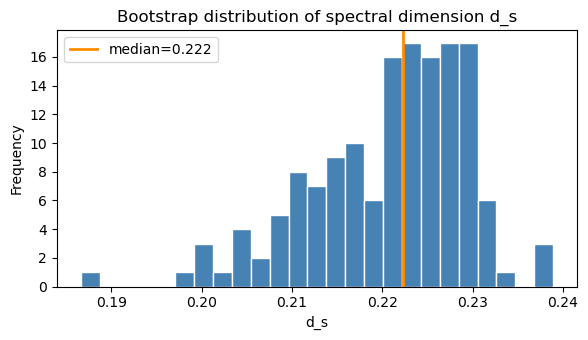

Saved: results/spectral_dimension_bootstrap.csv and results/spectral_dimension_bootstrap_hist.png


In [4]:
# Cell: Bootstrap spectral-dimension estimation by node subsampling
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy import stats
import matplotlib.pyplot as plt

# Parameters (à ajuster si besoin)
csv_path = 'data/sunspots_raw/Sunspots.csv'
value_col_candidates = ['Number', 'Total Sunspot', 'Total Sunspot Number', 'Monthly Mean']
embedding_dim = 10
tau = 1
k_neighbors = 10
n_eig = 100
n_boot = 150            # nombre de rééchantillonnages bootstrap
subsample_frac = 0.8    # fraction de nœuds conservés à chaque bootstrap
lambda_max = 0.1        # plage de fit pour N(lambda)
min_points_for_fit = 8

os.makedirs('results', exist_ok=True)

# Load series and build full embedding (reuse logic of prior cell)
df = pd.read_csv(csv_path)
col = None
for c in value_col_candidates:
    if c in df.columns:
        col = c
        break
if col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise RuntimeError("No numeric column found in CSV.")
    col = numeric_cols[-1]

series = pd.to_numeric(df[col], errors='coerce').dropna().values
def takens_embed(x, dim, tau):
    m = len(x) - (dim - 1) * tau
    if m <= 0:
        raise ValueError("Embedding parameters too large for series length")
    embed = np.empty((m, dim))
    for i in range(dim):
        embed[:, i] = x[i * tau : i * tau + m]
    return embed

X_full = takens_embed(series, embedding_dim, tau)
n_nodes = X_full.shape[0]
print(f"Full embedding nodes: {n_nodes}")

def compute_ds_from_points(X_points, k_neighbors, n_eig, lambda_max, min_points_for_fit):
    # build kNN graph
    n_nodes_local = X_points.shape[0]
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors + 1, n_nodes_local), algorithm='auto').fit(X_points)
    distances, indices = nbrs.kneighbors(X_points)
    adj = sparse.lil_matrix((n_nodes_local, n_nodes_local), dtype=np.float32)
    for i in range(n_nodes_local):
        for j in indices[i, 1:]:
            adj[i, j] = 1.0
            adj[j, i] = 1.0
    adj = adj.tocsr()
    deg = np.array(adj.sum(axis=1)).flatten()
    deg[deg == 0] = 1.0
    D_inv_sqrt = sparse.diags(1.0 / np.sqrt(deg))
    I = sparse.identity(n_nodes_local, format='csr')
    L_norm = I - D_inv_sqrt @ adj @ D_inv_sqrt
    # eigenvalues
    n_eig_local = min(n_eig, n_nodes_local - 1)
    try:
        eigvals, _ = eigsh(L_norm, k=n_eig_local, which='SM', tol=1e-6, maxiter=5000)
    except Exception as e:
        # fallback: dense eigen decomposition for small n
        try:
            from scipy.linalg import eigh
            Ld = L_norm.toarray()
            eigvals_all = eigh(Ld, eigvals_only=True)
            eigvals = np.sort(eigvals_all)[:n_eig_local]
        except Exception as e2:
            return None
    eigvals = np.sort(eigvals)
    # spectral counting
    eps = 1e-12
    lams = eigvals[eigvals > eps]
    if lams.size == 0:
        return None
    lam_vals = np.unique(lams)
    N_vals = np.array([np.searchsorted(lams, lam, side='right') for lam in lam_vals])
    mask = lam_vals <= lambda_max
    lam_fit = lam_vals[mask]
    N_fit = N_vals[mask]
    if len(lam_fit) < min_points_for_fit:
        return None
    log_lam = np.log(lam_fit)
    log_N = np.log(N_fit)
    slope, intercept, r_value, p_value, stderr = stats.linregress(log_lam, log_N)
    d_s_est = 2.0 * slope
    return {'d_s': d_s_est, 'slope': slope, 'stderr_slope': stderr, 'r': r_value, 'n_fit': len(lam_fit)}

# Bootstrap loop
results = []
rng = np.random.default_rng(42)
for b in range(n_boot):
    # subsample indices
    idx = rng.choice(np.arange(n_nodes), size=int(np.floor(subsample_frac * n_nodes)), replace=False)
    X_sub = X_full[idx, :]
    res = compute_ds_from_points(X_sub, k_neighbors, n_eig, lambda_max, min_points_for_fit)
    if res is not None:
        res['b'] = b + 1
        res['n_nodes_sub'] = X_sub.shape[0]
        results.append(res)
    else:
        # record failure
        results.append({'b': b + 1, 'd_s': np.nan, 'slope': np.nan, 'stderr_slope': np.nan, 'r': np.nan, 'n_fit': 0, 'n_nodes_sub': X_sub.shape[0]})

res_df = pd.DataFrame(results)
res_df.to_csv('results/spectral_dimension_bootstrap.csv', index=False)

# Summaries and plot
valid = res_df['d_s'].dropna()
print(f"Bootstrap completed: {len(valid)} valid estimates out of {n_boot}")
if len(valid) > 0:
    median = float(valid.median())
    mean = float(valid.mean())
    std = float(valid.std(ddof=1))
    lo = float(np.quantile(valid, 0.025))
    hi = float(np.quantile(valid, 0.975))
    print(f"d_s median={median:.4f}, mean={mean:.4f}, std={std:.4f}, 95% CI=({lo:.4f}, {hi:.4f})")
    plt.figure(figsize=(6,3.5))
    plt.hist(valid, bins=25, color='steelblue', edgecolor='white')
    plt.axvline(median, color='darkorange', lw=2, label=f'median={median:.3f}')
    plt.title('Bootstrap distribution of spectral dimension d_s')
    plt.xlabel('d_s')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig('results/spectral_dimension_bootstrap_hist.png', dpi=150)
    plt.show()
else:
    print("No valid estimates obtained; consider increasing lambda_max or lowering min_points_for_fit.")

print("Saved: results/spectral_dimension_bootstrap.csv and results/spectral_dimension_bootstrap_hist.png")


# todo_Tlog_from_ds.txt

Objectif:
- Propager la distribution bootstrap de la dimension spectrale d_s vers une distribution empirique de T_log pour la taille observée n (par défaut n=3265).
- Sauvegarder les échantillons T_log, un résumé statistique et un histogramme.

Entrées:
- results/spectral_dimension_bootstrap.csv (colonne d_s)

Paramètres modifiables:
- n_value: taille n utilisée pour le calcul de T_log (actuellement 3265)
- bias: biais ajouté si tu veux tester autres hypothèses (par défaut 0)

Sorties:
- results/Tlog_from_ds_bootstrap.csv (colonnes: d_s, T_log)
- results/Tlog_from_ds_bootstrap_summary.csv (résumé statistique)
- results/Tlog_from_ds_bootstrap_hist.png (histogramme)





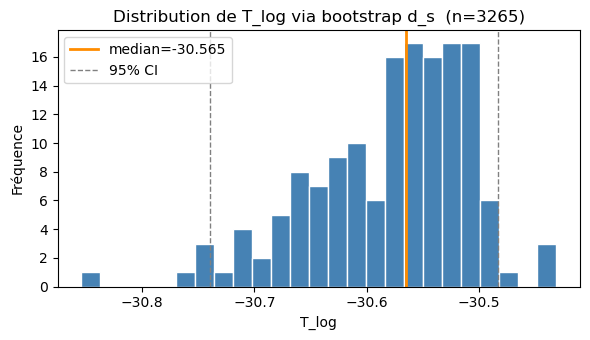

Résumé T_log:
 - n: 3265
 - N_ds_samples: 150
 - Tlog_mean: -30.578871481179583
 - Tlog_median: -30.565215538037325
 - Tlog_std: 0.07097938879828052
 - Tlog_95ci_lo: -30.740031636902394
 - Tlog_95ci_hi: -30.483265102737043
 - Tlog_min: -30.854294116840762
 - Tlog_max: -30.431059651418135
 - bias_used: 0.0
Saved samples: results/Tlog_from_ds_bootstrap.csv
Saved summary: results/Tlog_from_ds_bootstrap_summary.csv
Saved plot: results/Tlog_from_ds_bootstrap_hist.png


In [5]:
# Cell: Propagate spectral-dimension bootstrap (d_s samples) to T_log distribution for given n
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres
n_value = 3265                         # taille observée (n) utilisée précédemment
ds_boot_csv = 'results/spectral_dimension_bootstrap.csv'
out_csv = 'results/Tlog_from_ds_bootstrap.csv'
out_png = 'results/Tlog_from_ds_bootstrap_hist.png'
bias = 0.0                              # biais si applicable

os.makedirs('results', exist_ok=True)

# Charger bootstrap d_s
df = pd.read_csv(ds_boot_csv)
if 'd_s' not in df.columns:
    raise RuntimeError(f"File {ds_boot_csv} does not contain 'd_s' column")

ds_samples = df['d_s'].dropna().values
if ds_samples.size == 0:
    raise RuntimeError("No valid d_s samples found in bootstrap file")

# Calculer T_log pour chaque échantillon de d_s
Tlog_samples = (ds_samples - 4.0) * np.log(n_value) + bias

# Résumés statistiques
median = float(np.median(Tlog_samples))
mean = float(np.mean(Tlog_samples))
std = float(np.std(Tlog_samples, ddof=1))
lo95 = float(np.quantile(Tlog_samples, 0.025))
hi95 = float(np.quantile(Tlog_samples, 0.975))
min_v = float(np.min(Tlog_samples))
max_v = float(np.max(Tlog_samples))

summary = {
    'n': n_value,
    'N_ds_samples': int(len(ds_samples)),
    'Tlog_mean': mean,
    'Tlog_median': median,
    'Tlog_std': std,
    'Tlog_95ci_lo': lo95,
    'Tlog_95ci_hi': hi95,
    'Tlog_min': min_v,
    'Tlog_max': max_v,
    'bias_used': bias
}

# Sauvegarde échantillons et résumé
pd.DataFrame({'d_s': ds_samples, 'T_log': Tlog_samples}).to_csv(out_csv, index=False)
pd.DataFrame([summary]).to_csv(out_csv.replace('.csv','_summary.csv'), index=False)

# Plot histogram
plt.figure(figsize=(6,3.5))
plt.hist(Tlog_samples, bins=25, color='steelblue', edgecolor='white')
plt.axvline(median, color='darkorange', lw=2, label=f'median={median:.3f}')
plt.axvline(lo95, color='gray', lw=1, linestyle='--', label='95% CI')
plt.axvline(hi95, color='gray', lw=1, linestyle='--')
plt.title(f'Distribution de T_log via bootstrap d_s  (n={n_value})')
plt.xlabel('T_log')
plt.ylabel('Fréquence')
plt.legend()
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()

print("Résumé T_log:")
for k,v in summary.items():
    print(f" - {k}: {v}")
print(f"Saved samples: {out_csv}")
print(f"Saved summary: {out_csv.replace('.csv','_summary.csv')}")
print(f"Saved plot: {out_png}")


Interprétation rapide des résultats obtenus
Estimation spectrale (bootstrap) : d_s médiane ≈ 0.222 (mean ≈ 0.221), 95% CI ≈ [0.201, 0.233]. Estimation robuste et étroite autour de ~0.22.

Propagation vers T_log (n = 3265) : distribution concentrée, median T_log ≈ -30.565, 95% CI ≈ [-30.740, -30.483]. T_log est nettement négatif → régime Divergence pour les définitions actuelles de n et d.

Conclusion opérationnelle : avec d_est ~0.22 la classification est sans ambiguïté (p(T_log<0) ≈ 1). Pour avancer : calculer les probabilités exactes des trois régimes (Saturation / Équilibre / Divergence) en tenant compte d’une tolérance autour de 0 pour "≈0", et décider si tu veux étudier T_log sur fenêtres glissantes ou tester null‑models.

Prochaine cellule Python — calculer les probabilités des régimes (avec tolérance pour équilibre)

# todo_Tlog_regime_probabilities.txt

Objectif:
- Calculer la probabilité empirique que le système soit en Saturation (T_log > +tol),
  en Équilibre (|T_log| ≤ tol), ou en Divergence (T_log < -tol) en utilisant la distribution bootstrap de T_log.

Paramètres à ajuster:
- tol_equilibrium: la tolérance autour de 0 considérée comme "≈0" (ex. 0.01). Peut être élargi à 0.1 ou 0.5 selon la granularité souhaitée.

Entrées:
- results/Tlog_from_ds_bootstrap.csv

Sorties:
- results/Tlog_regime_probabilities.csv (résumé avec p_saturation, p_equilibrium, p_divergence)
- Console: probabilités imprimées



In [6]:
# Cell: Compute regime probabilities from T_log bootstrap samples
import numpy as np
import pandas as pd
import os

# Inputs / params
tlog_csv = 'results/Tlog_from_ds_bootstrap.csv'   # produced earlier
tol_equilibrium = 0.01   # tolerance for "≈0" (adjustable)
out_summary = 'results/Tlog_regime_probabilities.csv'

# Load
df = pd.read_csv(tlog_csv)
if 'T_log' not in df.columns:
    raise RuntimeError(f"{tlog_csv} missing T_log column")
tlogs = df['T_log'].dropna().values

# Compute probabilities
p_saturation = float(np.mean(tlogs > tol_equilibrium))
p_equilibrium = float(np.mean(np.abs(tlogs) <= tol_equilibrium))
p_divergence = float(np.mean(tlogs < -tol_equilibrium))

# For completeness, show small-|T_log| mass within a slightly larger tolerance too
tol2 = 0.1
p_equilibrium_tol2 = float(np.mean(np.abs(tlogs) <= tol2))

summary = {
    'n_samples': int(len(tlogs)),
    'tol_equilibrium': float(tol_equilibrium),
    'p_saturation': p_saturation,
    'p_equilibrium': p_equilibrium,
    'p_divergence': p_divergence,
    'tol_equilibrium_alt': tol2,
    'p_equilibrium_tol2': p_equilibrium_tol2,
    'Tlog_median': float(np.median(tlogs)),
    'Tlog_mean': float(np.mean(tlogs))
}

os.makedirs('results', exist_ok=True)
pd.DataFrame([summary]).to_csv(out_summary, index=False)

print("Regime probabilities (using T_log bootstrap samples):")
for k, v in summary.items():
    print(f" - {k}: {v}")
print(f"\nSaved summary to {out_summary}")


Regime probabilities (using T_log bootstrap samples):
 - n_samples: 150
 - tol_equilibrium: 0.01
 - p_saturation: 0.0
 - p_equilibrium: 0.0
 - p_divergence: 1.0
 - tol_equilibrium_alt: 0.1
 - p_equilibrium_tol2: 0.0
 - Tlog_median: -30.565215538037325
 - Tlog_mean: -30.578871481179576

Saved summary to results/Tlog_regime_probabilities.csv


Constat rapide
Tu as p(T_log < 0) = 1 avec la définition actuelle (d_est ≈ 0.22, n = 3265). Prochaine étape logique : confronter cette conclusion à des null‑models pour vérifier que la valeur négative de T_log n’est pas une conséquence triviale du prétraitement (embedding, kNN, etc.) ou de simples propriétés statistiques de la série. Je fournis la cellule suivante qui génère deux null‑models (temporal shuffle et phase‑randomized surrogate), estime la dimension spectrale pour chacun (bootstrap), puis compare la distribution de d_s et de T_log aux observés.

Cellule Python (exécuter — prend du temps) :